In [5]:
%load_ext autoreload
%autoreload 2

# import matplotlib as mpl
# mpl.use('Agg')

from IPython.display import display
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
from sklearn.ensemble import RandomForestClassifier

# from BackwardImplementation_fromPaper import prepare_training_data, backward_implementation_from_paper

import sys
sys.path.append('..')
from helper.orderbook_trader import OrderbookTradingSimulator
from helper.Q_learning import QLearn, round_custombase
from helper.manage_orderbooks_v2 import OrderbookEpisodesGenerator, plot_episode, load_orderbook_snapshot
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
V = 100
vol_intervals = 10
T = 4
P = 15

modelname = 'models/obs_2016-11_USDT_BTC_range1.2_ALLsamples.json'
# samples = 2

actions = list(np.linspace(-0.4, 1.0, num=15))
print("V={}, T={}, P={}".format(V, T, P))
print("Actions: ", ", ".join(["{:1.2f}".format(a) for a in actions]))

V=100, T=4, P=15
Actions:  -0.40, -0.30, -0.20, -0.10, -0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00


In [3]:
filename_train = '/home/axel/data/obs_2016-11_USDT_BTC_range1.2.dict'
filename_test = '/home/axel/data/obs_2017-02_USDT_BTC_range1.2.dict'

episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*P)
print("Length of episodes_train: {}".format(len(episodes_train)))
# episode_windows_train = prepare_training_data(filename, samples=samples, T=T, P=P, first_line=0)

episodes_test = OrderbookEpisodesGenerator(filename=filename_test, episode_length=T*P)
print("Length of episodes_test: {}".format(len(episodes_test)))

Length of episodes_train: 541
Length of episodes_test: 670


/home/axel/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


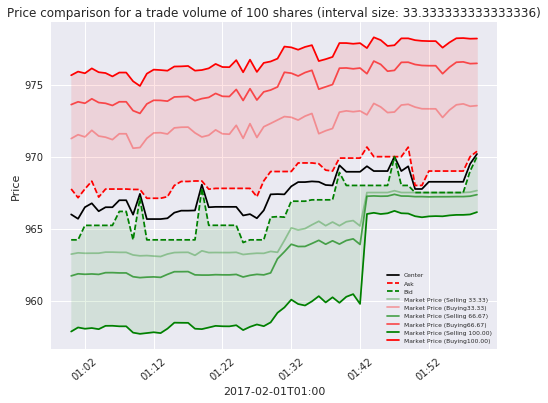

In [4]:
#plot_episode(episodes_train[5], volume=100)
#plot_episode(episodes_train[6], volume=100)
plot_episode(episodes_test[1], volume=100, intervals=3)

In [8]:
def extract_features():
    features = pd.DataFrame([], columns=['center', 'r15', 'r30', 'r45'])
    vol = 100

    for idx in tqdm(range(len(data)-60)):
        ob = data[idx]
        features.loc[idx,0:4] = [data[idx+offset].get_center() for offset in [0,15,30,45]]

        features.loc[idx, 'spread'] = ob.get_ask() - ob.get_bid()

        features.loc[idx, 'imbalance'] = ob.get_ask()/ob.get_bid()
        features.loc[idx, 'price_buy'] = ob.get_current_price(volume=vol)[0]
        features.loc[idx, 'price_sell'] = ob.get_current_price(volume=-vol)[0]
        # features.loc[idx, 'price_imbalance'] = df.loc[idx, 'price_buy'] / df.loc[idx, 'price_sell']

        features.loc[idx, 'price_centerOffset_buy'] = (features.loc[idx, 'price_buy']/100.) / features.loc[idx, 'center']
        features.loc[idx, 'price_centerOffset_sell'] = features.loc[idx, 'center'] / (features.loc[idx, 'price_sell']/100.)

        features.loc[idx, 'price_centerOffset'] = features.loc[idx, 'price_centerOffset_buy'] - features.loc[idx, 'price_centerOffset_sell']

    features[['r15', 'r30', 'r45']] = features[['center', 'r15', 'r30', 'r45']].pct_change(axis=1).dropna(axis=1)
    features.describe()
    
    return features
# features = extract_features()
# features.to_csv("features_Nov17.csv")
features = pd.read_csv("features_Nov17.csv", index_col=0)

In [12]:
rf = RandomForestClassifier(max_depth=6)
Y_values = ['r15', 'r30', 'r45']
y = features[Y_values]

for yy in Y_values:
    y = features[yy] >= 0
    X = features[['spread', 'imbalance', 'price_buy', 'price_sell', 'price_centerOffset_buy', 
                  'price_centerOffset_sell', 'price_centerOffset']]
    # X = features[['spread', 'imbalance', 'price_buy', 'price_sell', 'price_centerOffset']]
    rf.fit(X=X, y=y)
    print(rf.feature_importances_)
    print("score", rf.score(X=X, y=y))
    print("")

[ 0.07872279  0.07728359  0.11920839  0.14132625  0.11790505  0.25085962
  0.21469431]
score 0.634393687196

[ 0.08316645  0.0902404   0.17295014  0.19593334  0.12408928  0.20720766
  0.12641275]
score 0.586554466432

[ 0.0845858   0.09314281  0.14402949  0.17213333  0.15000067  0.23587511
  0.12023279]
score 0.578540163985



In [ ]:
# df = pd.DataFrame([])
O = 60

print(len(episodes_train))
for e, episode in tqdm(enumerate(episodes_train)):
    plot_episode(episode, volume=100, intervals=4)
    # init_center = episode[0].get_center()
    
    # performance = pd.DataFrame([episode[elem].get_center() for elem in [0,15,30,45]])
    # print(performance)
    # print(performance.pct_change())
    
    for o, ob in enumerate(episode):
        idx = e*O+o
        
        df.loc[idx, 'vol_imbalance']
#         x = pd.DataFrame([ob.get_center(), ob.get_ask()-ob.get_bid(), ob.get_bid()/ob.get_ask()])
        
        # df.loc[idx, 'center'] = ob.get_center()
        # df.loc[idx, 'spread'] = ob.get_ask()-ob.get_bid()
        # df.loc[idx, 'imbalance'] = ob.get_ask()/ob.get_bid()
        # df.loc[idx, 'price_buy'] = ob.get_current_price(volume=100)[0]
        # df.loc[idx, 'price_sell'] = ob.get_current_price(volume=-100)[0]
        # df.loc[idx, 'price_imbalance'] = df.loc[idx, 'price_buy'] / df.loc[idx, 'price_sell']
        # df.loc[idx, 'price_centerOffset_buy'] = df.loc[idx, 'price_buy']/100. - df.loc[idx, 'center']
        # df.loc[idx, 'price_centerOffset_sell'] = df.loc[idx, 'center'] - df.loc[idx, 'price_sell']/100.
        # 
        # df.loc[idx, 'price_centerOffset'] = df.loc[idx, 'price_centerOffset_buy'] / df.loc[idx, 'price_centerOffset_sell']
        

In [ ]:
df2 = features.copy()

In [ ]:
display(df2.describe())
df2.spread.quantile(0.67)

In [ ]:
df2.imbalance.plot()

In [ ]:
df = df2.copy()
df["spread"].plot()
#plt.box(df['spread'].values)
plt.show()
df["imbalance"].T.plot()
plt.show()
df["price_buy"].T.plot()
plt.show()
df["price_sell"].T.plot()
plt.show()

df["price_centerOffset_buy"].T.plot()
plt.show()

df["price_centerOffset_sell"].T.plot()

plt.show()
df["price_centerOffset"].T.plot()